In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize
import shap

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## Function Definition

### ExtraTrees

In [2]:
# classifier
def ExtraTreesC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = ExtraTreesClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor (optional)
def ExtraTreesR(train_x, test_x, train_y, test_y, config):
    
    clf = ExtraTreesRegressor(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


# classifier for all resampling datasets
def runall_ExtraTreesC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = ExtraTreesC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set
    

# regressor for all resampling datasets (optional)
def runall_ExtraTreesR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = ExtraTreesR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Probability Calibration (optional)

In [ ]:
def stratified_data(train_data, cv):
    
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    good_index = random.sample(good.index.to_list(), k = len(good))
    bad_index = random.sample(bad.index.to_list(), k = len(bad))
    
    train_x_dict = {}
    train_y_dict = {}
    valid_x_dict = {}
    valid_y_dict = {}
    for i in range(cv):
        
        if (i+1) == cv:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))): ]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))): ]
        else:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))) : int(np.floor(((i+1)/cv)*len(good)))]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))) : int(np.floor(((i+1)/cv)*len(bad)))]
        good_train_index = [x for x in good_index if x not in good_valid_index]
        bad_train_index = [x for x in bad_index if x not in bad_valid_index]
        
        good_train = good.loc[good_train_index]
        good_valid = good.loc[good_valid_index]
        bad_train = bad.loc[bad_train_index]
        bad_valid = bad.loc[bad_valid_index]
        train = pd.concat([good_train, bad_train], axis = 0)
        valid = pd.concat([good_valid, bad_valid], axis = 0)
        train_x_dict[i], train_y_dict[i], valid_x_dict[i], valid_y_dict[i] = label_divide(train, valid, train_only = False)

    return train_x_dict, train_y_dict, valid_x_dict, valid_y_dict


def beta_map(s, a, b, c):
    return 1 / (1 + 1 / (np.power(np.exp(1), c)*(np.power(s, a) / np.power(1-s, b))))
                

def self_loss(three, test_y, predict_y):
    a, b, c = three
    new_s = beta_map(predict_y, a, b, c)
    loss = np.mean(test_y*np.log(new_s) + (1 - test_y)*np.log(1 - new_s))*(-1)
    return loss


def beta_ExtraTreesC(train_x, train_y, test_x, test_y, config, loss_function = self_loss):
    
    train = pd.concat([train_x, train_y], axis = 1)
    train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train, cv = 5)
    
    cali_param = {}
    for i in range(len(train_x_dict)):
        clf = ExtraTreesClassifier(**config)
        clf.fit(train_x_dict[i], train_y_dict[i])
        predict_y = clf.predict_proba(valid_x_dict[i])[:, 1]
        mini_result = minimize(loss_function, [0.5, 0.5, 0.5], (valid_y_dict[i], predict_y))
        cali_param[i] = mini_result.x
        
    clf = ExtraTreesClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    
    cali_predict = np.array(0).astype(float)
    for i in range(len(cali_param)):
        cali_result = beta_map(predict_y, *cali_param[i])
        cali_predict = cali_predict + cali_result
    cali_predict /= len(cali_param)
      
    predict = (cali_predict > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})

    return result


def cali_ExtraTreesC(train_x, train_y, test_x, test_y, config, method):
    
    clf = ExtraTreesClassifier(**config)
    cali_clf = CalibratedClassifierCV(clf, method = method, cv = 5)
    cali_clf.fit(train_x, train_y)
    predict_y = cali_clf.predict_proba(test_x)[:, 1]
    predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})
    
    return result 


def all_cali_ExtraTreesC(trainset_x, trainset_y, test_x, test_y, config_dict, method):
    
    keys = config_dict.keys()
    all_result = pd.DataFrame()
    for i in keys:
        print('\n', f'Data{i}:')
        
        if method in ['isotonic', 'sigmoid']:
            table = cali_ExtraTreesC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i], method)
        elif method == 'beta':
            table = beta_ExtraTreesC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i])
        result_df = cf_matrix(table, trainset_y[i])
        all_result = pd.concat([all_result, result_df], axis = 0).rename(index = {0: f'data{i}'})
        
    return all_result

### Optuna

In [3]:
# creator od optuna study for extra trees
def ExtraTrees_creator(train_data, mode, num_valid = 5, label = 'GB') :
    
    def objective(trial) :

        param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 12, step = 2),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3)
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            
            if mode == 'C':
                result = ExtraTreesC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = ExtraTreesR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

### Full Experiment

In [4]:
def full_extratrees(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_ExtraTrees_{i}',
                                         creator = ExtraTrees_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = ExtraTreesC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], 
                                return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## Prediction

### For a Run

#### Load Data

In [ ]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')
 
print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)

#### Search for The Best Hyperparameters

In [ ]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 20, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_ExtraTrees', 
                                     creator = ExtraTrees_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'ExtraTrees Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Classifier

In [ ]:
table_setC = runall_ExtraTreesC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'ExtraTrees Classifier')

In [ ]:
table_setC

#### Calibrated Classifier (optional)

In [ ]:
tableC_1 = all_cali_ExtraTreesC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'isotonic')
tableC_2 = all_cali_ExtraTreesC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'sigmoid')
tableC_3 = all_cali_ExtraTreesC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'beta')

#### Feature Importance

In [ ]:
target = 'set7'

model = ExtraTreesClassifier(**best_paramC[target])
model.fit(run_train_x[target], run_train_y[target])
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(run_train_x[target])
values = abs(shap_values[1]).mean(axis = 0)

shap.summary_plot(shap_values, run_train_x[target])
shap.dependence_plot('label_eqp_ADIEXA00', shap_values[1], run_train_x[target])
shap.dependence_plot('label_eqp_ADCVD200_C', shap_values[1], run_train_x[target])

In [ ]:
fig = plt.figure(figsize = (24, 8))
colname = run_train[target].columns.to_list()[:-1]
importance = (model.feature_importances_).tolist()
plt.bar(colname, values, color = 'orange')
plt.xticks(rotation = 90)
plt.title('20211228_ExtraTrees_ShapValue')
fig = plt.figure(figsize = (24, 8))
plt.bar(colname, importance, color = 'purple')
plt.xticks(rotation = 90)
plt.title('20211228_ExtraTrees_TreeBasedImportance')

#### Regressor (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m5_4selection_ExtraTrees', 
                                     creator = ExtraTrees_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_ExtraTreesR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                         thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'ExtraTrees Regressor')

In [ ]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_extratrees(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 165
# over: 165
Size after Border: 39627

 Generating Dataset 2
Size after Undersampling: 1374
Size after Undersampling: (1374, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 13:45:02,897] A new study created in memory with name: no-name-e909cfb7-1dca-4e51-9557-db48dce63b17


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
Precision: 0.993421052631579 
Recall: 0.984354628422425 
Aging Rate: 0.4954367666232073
Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
[I 2022-05-09 13:45:04,736] Trial 0 finished with value: 0.9906134031870769 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 0 with value: 0.9906134031870769.
Precision: 0.9478609625668449 
Recall: 0.924380704041721 
Aging Rate: 0.4876140808344198
Precision: 0.9540078843626807 
Recall: 0.9465449804432855 
Aging Rate: 0.49608865710560623
Precision: 0.9588313413014609 
Recall: 0.9413298565840938 
Aging Rate: 0.4908735332464146
[I 2022-05-09 13:45:06,616] Trial 1 finished with value: 0.9454117924881493 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 0 with value: 0.9906134031870769.
Precision: 0.9501965923984272 
Recall: 0.9452411994784

Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106
Precision: 0.9973890339425587 
Recall: 0.9960886571056062 
Aging Rate: 0.49934810951760106
Precision: 0.9973684210526316 
Recall: 0.9882659713168188 
Aging Rate: 0.4954367666232073
[I 2022-05-09 13:45:49,604] Trial 17 finished with value: 0.9936848832346317 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 15 with value: 0.9956446885565314.
Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
[I 2022-05-09 13:45:53,840] Trial 18 finished with value: 0.9923975775505586 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 15 with value: 0.9956446885565314.
Precision: 0.9921976592977894 
Recall: 0.994784876140

[I 2022-05-09 13:46:13,881] A new study created in memory with name: no-name-7e9b9c28-7078-49ad-804f-3a8ee0ce102f


Precision: 0.9973753280839895 
Recall: 0.9908735332464146 
Aging Rate: 0.49674054758800523
[I 2022-05-09 13:46:13,787] Trial 24 finished with value: 0.9923556734749294 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 15 with value: 0.9956446885565314.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9750656167979003 
Recall: 0.9893475366178429 
Aging Rate: 0.507323568575233
Precision: 0.970013037809648 
Recall: 0.9906790945406125 
Aging Rate: 0.5106524633821571
Precision: 0.9828496042216359 
Recall: 0.9920106524633822 
Aging Rate: 0.5046604527296937
[I 2022-05-09 13:46:15,237] Trial 0 finished with value: 0.9832668979399561 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9832668979399561.
Precision: 0.9802371541501976 
Recall: 0.9906790945406125 
Aging Rate: 0.5053262316910786
Precision: 0.9763157894736842 
Recall: 0.9880159786950732 
Aging Rate: 0.5059920106524634
Precision: 0.9698558322411533 
Recall: 0.9853528628495339 
Aging Rate: 0.5079893475366178
[I 2022-05-09 13:46:16,169] Trial 1 finished with value: 0.9817014784173153 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 0 with value: 0.9832668979399561.
Precision: 0.9828947368421053 
Recall: 0.9946737683089

Precision: 0.9788079470198675 
Recall: 0.9840213049267643 
Aging Rate: 0.5026631158455392
Precision: 0.9774236387782205 
Recall: 0.9800266311584553 
Aging Rate: 0.5013315579227696
Precision: 0.9759036144578314 
Recall: 0.9707057256990679 
Aging Rate: 0.4973368841544607
[I 2022-05-09 13:46:42,794] Trial 17 finished with value: 0.9778096123618786 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 12}. Best is trial 2 with value: 0.9882813719014555.
Precision: 0.9588477366255144 
Recall: 0.9307589880159787 
Aging Rate: 0.48535286284953394
Precision: 0.9468791500664011 
Recall: 0.9494007989347537 
Aging Rate: 0.5013315579227696
Precision: 0.9512855209742895 
Recall: 0.9360852197070573 
Aging Rate: 0.49201065246338216
[I 2022-05-09 13:46:43,783] Trial 18 finished with value: 0.9454523511802534 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 2 with value: 0.9882813719014555.
Precision: 0.9800266311584553 
Recall: 0.9800266

[I 2022-05-09 13:46:50,805] A new study created in memory with name: no-name-8dbcff3e-e148-46ef-af34-5bcb15fd522a


Precision: 0.9739583333333334 
Recall: 0.996005326231691 
Aging Rate: 0.511318242343542
[I 2022-05-09 13:46:50,731] Trial 24 finished with value: 0.9883346861513119 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 24 with value: 0.9883346861513119.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.45
Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
Precision: 1.0 
Recall: 0.8921052631578947 
Aging Rate: 0.44605263157894737
[I 2022-05-09 13:46:52,716] Trial 0 finished with value: 0.9441951855014108 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 0 with value: 0.9441951855014108.
Precision: 1.0 
Recall: 0.8934210526315789 
Aging Rate: 0.44671052631578945
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
[I 2022-05-09 13:46:56,320] Trial 1 finished with value: 0.9441968787982967 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 1 with value: 0.9441968787982967.
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.4473684210526316
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
Precision: 1.0 
Reca

Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
[I 2022-05-09 13:47:44,495] Trial 19 finished with value: 0.9519350693214038 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 10 with value: 0.9545997365298766.
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.8855263157894737 
Aging Rate: 0.44276315789473686
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-05-09 13:47:48,147] Trial 20 finished with value: 0.9478176520639282 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 15}. Best is trial 10 with value: 0.9545997365298766.
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate:

[I 2022-05-09 13:47:55,987] A new study created in memory with name: no-name-1f6f9de9-b37d-4825-bba1-7b39530a35ec


Precision: 1.0 
Recall: 0.8828947368421053 
Aging Rate: 0.44144736842105264
[I 2022-05-09 13:47:55,886] Trial 24 finished with value: 0.9467829565235006 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 10 with value: 0.9545997365298766.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2022-05-09 13:48:00,157] Trial 0 finished with value: 0.9882536498891064 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 0 with value: 0.9882536498891064.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2022-05-09 13:48:01,082] Trial 1 finished with value: 0.9869477112707488 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9882536498891064.
Precision: 0.8425655976676385 
Recall: 0.7605263157894737 
Aging Rate: 0.4513157894736842
Precision: 0

Precision: 0.9958960328317373 
Recall: 0.9578947368421052 
Aging Rate: 0.48092105263157897
[I 2022-05-09 13:48:31,938] Trial 17 finished with value: 0.9790199442175886 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 16 with value: 0.9913726083179899.
Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.4888157894736842
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-05-09 13:48:33,345] Trial 18 finished with value: 0.9849184126769686 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 16 with value: 0.9913726083179899.
Precision: 1.0 
Recall: 0.9605263157894737 
Aging Rate: 0.48026315789473684
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 

[I 2022-05-09 13:48:42,029] A new study created in memory with name: no-name-4fc6cab4-d5ac-49d0-b45f-47b47d3bc3a3


Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2022-05-09 13:48:41,954] Trial 24 finished with value: 0.9844355229273032 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 16 with value: 0.9913726083179899.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9973226238286479 
Recall: 0.9867549668874173 
Aging Rate: 0.49306930693069306
Precision: 1.0 
Recall: 0.9933774834437086 
Aging Rate: 0.49504950495049505
Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
[I 2022-05-09 13:48:46,140] Trial 0 finished with value: 0.994233456458358 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 0 with value: 0.994233456458358.
Precision: 0.9946808510638298 
Recall: 0.990728476821192 
Aging Rate: 0.49636963696369635
Precision: 0.9959731543624161 
Recall: 0.9827814569536424 
Aging Rate: 0.49174917491749176
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-05-09 13:48:47,095] Trial 1 finished with value: 0.9922453500051024 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 0 with value: 0.994233456458358.
Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Agin

Precision: 0.998661311914324 
Recall: 0.9880794701986755 
Aging Rate: 0.49306930693069306
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
[I 2022-05-09 13:49:15,208] Trial 17 finished with value: 0.9931454094297716 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 9 with value: 0.9951311752702354.
Precision: 0.9986577181208054 
Recall: 0.9854304635761589 
Aging Rate: 0.49174917491749176
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 0.9973474801061007 
Recall: 0.9960264900662251 
Aging Rate: 0.4976897689768977
[I 2022-05-09 13:49:16,672] Trial 18 finished with value: 0.9940125370707199 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 9 with value: 0.9951311752702354.
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9946808510638298 
Recall: 0.990728

[I 2022-05-09 13:49:25,042] A new study created in memory with name: no-name-baa8c38d-497f-4f8f-9e81-db1360f3d534


Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
[I 2022-05-09 13:49:24,948] Trial 24 finished with value: 0.9957909207322982 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 21 with value: 0.9957932757710392.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.978891820580475 
Recall: 0.9933065595716198 
Aging Rate: 0.5029860650298607
Precision: 0.9840848806366048 
Recall: 0.9933065595716198 
Aging Rate: 0.5003317850033179
Precision: 0.9866310160427807 
Recall: 0.9879518072289156 
Aging Rate: 0.49635036496350365
[I 2022-05-09 13:49:29,367] Trial 0 finished with value: 0.9873372329053712 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 0 with value: 0.9873372329053712.
Precision: 0.9154727793696275 
Recall: 0.8554216867469879 
Aging Rate: 0.46317186463171867
Precision: 0.8977591036414566 
Recall: 0.85809906291834 
Aging Rate: 0.47378898473788983
Precision: 0.8892005610098177 
Recall: 0.8487282463186078 
Aging Rate: 0.47312541473125413
[I 2022-05-09 13:49:33,201] Trial 1 finished with value: 0.876801131234905 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 0 with value: 0.9873372329053712.
Precision: 0.9800266311584553 
Recall: 0.9852744310

Precision: 0.9813581890812251 
Recall: 0.9866131191432396 
Aging Rate: 0.49834107498341074
Precision: 0.983957219251337 
Recall: 0.9852744310575636 
Aging Rate: 0.49635036496350365
Precision: 0.9814323607427056 
Recall: 0.9906291834002677 
Aging Rate: 0.5003317850033179
[I 2022-05-09 13:50:19,695] Trial 17 finished with value: 0.9848677833049623 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 15}. Best is trial 8 with value: 0.9933137119595985.
Precision: 0.9892617449664429 
Recall: 0.9866131191432396 
Aging Rate: 0.49435965494359657
Precision: 0.9762532981530343 
Recall: 0.9906291834002677 
Aging Rate: 0.5029860650298607
Precision: 0.9854304635761589 
Recall: 0.9959839357429718 
Aging Rate: 0.5009953550099535
[I 2022-05-09 13:50:20,670] Trial 18 finished with value: 0.9873344852320033 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 8 with value: 0.9933137119595985.
Precision: 0.8365695792880259 
Recall: 0.692101

[I 2022-05-09 13:50:44,438] A new study created in memory with name: no-name-fc7ff76b-1041-418a-9389-df3b7c380b30


Precision: 0.9737876802096985 
Recall: 0.9946452476572959 
Aging Rate: 0.5063039150630392
[I 2022-05-09 13:50:44,375] Trial 24 finished with value: 0.9873440283936507 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 8 with value: 0.9933137119595985.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
[I 2022-05-09 13:50:48,129] Trial 0 finished with value: 0.9488179645563944 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 0 with value: 0.9488179645563944.
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
[I 2022-05-09 13:50:49,564] Trial 1 finished with value: 0.9531670503358094 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 1 with value: 0.9531670503358094.
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.456

Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
[I 2022-05-09 13:51:21,024] Trial 19 finished with value: 0.9567483161366256 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 19 with value: 0.9567483161366256.
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
[I 2022-05-09 13:51:24,752] Trial 20 finished with value: 0.9483279837200725 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 19 with value: 0.9567483161366256.
Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
Precision: 0.9970193740685543 
Recall: 0.8802631578947369 

[I 2022-05-09 13:51:39,694] A new study created in memory with name: no-name-90d8b6b5-3eaa-4cb7-9d01-a47fefed8a2c


Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
[I 2022-05-09 13:51:39,592] Trial 24 finished with value: 0.9539120675427469 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 22 with value: 0.9598506094876412.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9834938101788171 
Recall: 0.9407894736842105 
Aging Rate: 0.47828947368421054
Precision: 0.9905020352781547 
Recall: 0.9605263157894737 
Aging Rate: 0.48486842105263156
Precision: 0.9743243243243244 
Recall: 0.9486842105263158 
Aging Rate: 0.4868421052631579
[I 2022-05-09 13:51:40,557] Trial 0 finished with value: 0.9660950073201772 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 9}. Best is trial 0 with value: 0.9660950073201772.
Precision: 0.9850136239782016 
Recall: 0.9513157894736842 
Aging Rate: 0.48289473684210527
Precision: 0.9807956104252401 
Recall: 0.9407894736842105 
Aging Rate: 0.47960526315789476
Precision: 0.9850746268656716 
Recall: 0.9552631578947368 
Aging Rate: 0.48486842105263156
[I 2022-05-09 13:51:41,508] Trial 1 finished with value: 0.9660624856799206 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 9}. Best is trial 0 with value: 0.9660950073201772.
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875

Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 13:52:11,982] Trial 17 finished with value: 0.9851212639182839 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 12 with value: 0.9887004458332965.
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2022-05-09 13:52:12,887] Trial 18 finished with value: 0.9868976198636229 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 12 with value: 0.9887004458332965.
Precision: 0.99055330634278 
Recall: 0.9657894736842105 
Aging Rate: 0.4875
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.9959294436906377 
Recall: 0.9657894736842105 
Aging Rate: 0.48486842105263156
[I 2022-05-09 13:52:16,792] Trial 19

[I 2022-05-09 13:52:24,819] A new study created in memory with name: no-name-2d6e6c15-4593-467b-b773-73c4093443bd


Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-05-09 13:52:24,728] Trial 24 finished with value: 0.9875942408515361 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 23 with value: 0.990488240077349.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9795918367346939 
Recall: 0.631578947368421 
Aging Rate: 0.05861244019138756
Precision: 0.9672131147540983 
Recall: 0.7763157894736842 
Aging Rate: 0.0729665071770335
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
[I 2022-05-09 13:52:26,191] Trial 0 finished with value: 0.8217115880451756 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 0 with value: 0.8217115880451756.
Precision: 0.9302325581395349 
Recall: 0.5263157894736842 
Aging Rate: 0.05143540669856459
Precision: 1.0 
Recall: 0.6710526315789473 
Aging Rate: 0.061004784688995214
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0645933014354067
[I 2022-05-09 13:52:29,926] Trial 1 finished with value: 0.7636010430822844 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 0 with value: 0.8217115880451756.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 13:52:31,975] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 0 with value: 0.8217115880451756.
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 1.0 
Recall: 0.8421052631578947 
Aging Rate: 0.07655502392344497
[I 2022-05-09 13:52:33,903] Trial 3 finished with value: 0.8682919419761524 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 3 with value: 0.8682919419761524.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
[I 2022-05-09 13:52:34,855] Trial 4 finished with value: 0.1299607825627516 and parame

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 13:52:38,425] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 3}. Best is trial 3 with value: 0.8682919419761524.
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
Precision: 0.9444444444444444 
Recall: 0.6710526315789473 
Aging Rate: 0.0645933014354067
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
[I 2022-05-09 13:52:39,350] Trial 6 finished with value: 0.8519767492061995 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 3 with value: 0.8682919419761524.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 13:52:42,727] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 3 with value: 0.8682919419761524.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2022-05-09 13:52:43,643] Trial 8 finished with value: 0.1433938847438564 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 3 with value: 0.8682919419761524.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 13:52:45,618] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 3}. Best is trial 3 with value: 0.8682919419761524.
Precision: 1.0 
Recall: 0.4868421052631579 
Aging Rate: 0.04425837320574163
Precision: 1.0 
Recall: 0.4342105263157895 
Aging Rate: 0.039473684210526314
Precision: 1.0 
Recall: 0.42105263157894735 
Aging Rate: 0.03827751196172249
[I 2022-05-09 13:52:47,554] Trial 10 finished with value: 0.6176548121285746 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 3 with value: 0.8682919419761524.
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 1.0 
Recall: 0.8157894736842105 
Aging Rate: 0.07416267942583732
[I 2022-05-09 13:52:48,477] Trial 11 finished with value: 0.9021446651619304 and parameters

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39623

 Generating Dataset 2
Size after Undersampling: 1366
Size after Undersampling: (1366, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 13:54:53,097] A new study created in memory with name: no-name-68efdbf7-b14e-48b8-a2de-7438f50d92d8


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9854689564068693 
Recall: 0.9726205997392438 
Aging Rate: 0.4934810951760104
Precision: 0.984313725490196 
Recall: 0.9817470664928292 
Aging Rate: 0.49869621903520206
Precision: 0.9856020942408377 
Recall: 0.9817470664928292 
Aging Rate: 0.4980443285528031
[I 2022-05-09 13:54:54,470] Trial 0 finished with value: 0.9819007162316736 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.9819007162316736.
Precision: 0.997364953886693 
Recall: 0.9869621903520208 
Aging Rate: 0.49478487614080835
Precision: 0.9986859395532195 
Recall: 0.9908735332464146 
Aging Rate: 0.49608865710560623
Precision: 0.9947368421052631 
Recall: 0.9856584093872229 
Aging Rate: 0.4954367666232073
[I 2022-05-09 13:54:59,096] Trial 1 finished with value: 0.9923591730858234 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 15}. Best is trial 1 with value: 0.9923591730858234.
Precision: 0.9702702702702702 
Recall: 0.936114732

Precision: 1.0 
Recall: 0.9895697522816167 
Aging Rate: 0.49478487614080835
Precision: 1.0 
Recall: 0.9895697522816167 
Aging Rate: 0.49478487614080835
Precision: 0.9986876640419947 
Recall: 0.9921773142112125 
Aging Rate: 0.49674054758800523
[I 2022-05-09 13:55:42,704] Trial 17 finished with value: 0.9949789721421958 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 15 with value: 0.996079850680747.
Precision: 0.9881422924901185 
Recall: 0.9778357235984355 
Aging Rate: 0.49478487614080835
Precision: 0.9893758300132802 
Recall: 0.9713168187744459 
Aging Rate: 0.4908735332464146
Precision: 0.9959946595460614 
Recall: 0.9726205997392438 
Aging Rate: 0.48826597131681876
[I 2022-05-09 13:55:46,829] Trial 18 finished with value: 0.9824646718221324 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 15 with value: 0.996079850680747.
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.5

[I 2022-05-09 13:56:03,825] A new study created in memory with name: no-name-eaad05dc-119f-42f6-833d-0b11c53061be


Precision: 0.9986893840104849 
Recall: 0.9934810951760105 
Aging Rate: 0.4973924380704042
[I 2022-05-09 13:56:03,741] Trial 24 finished with value: 0.9930060213061602 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 15 with value: 0.996079850680747.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8993103448275862 
Recall: 0.8681757656458056 
Aging Rate: 0.4826897470039947
Precision: 0.8963165075034106 
Recall: 0.8748335552596538 
Aging Rate: 0.48801597869507324
Precision: 0.8987688098495212 
Recall: 0.8748335552596538 
Aging Rate: 0.4866844207723036
[I 2022-05-09 13:56:05,211] Trial 0 finished with value: 0.8851844182456725 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 0 with value: 0.8851844182456725.
Precision: 0.8917456021650879 
Recall: 0.877496671105193 
Aging Rate: 0.49201065246338216
Precision: 0.8884462151394422 
Recall: 0.8908122503328895 
Aging Rate: 0.5013315579227696
Precision: 0.9073569482288828 
Recall: 0.8868175765645806 
Aging Rate: 0.48868175765645805
[I 2022-05-09 13:56:06,636] Trial 1 finished with value: 0.8903870383111423 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 1 with value: 0.8903870383111423.
Precision: 0.9528936742934051 
Recall: 0.9427430093

Precision: 0.9707446808510638 
Recall: 0.9720372836218375 
Aging Rate: 0.5006657789613849
Precision: 0.9865771812080537 
Recall: 0.9786950732356857 
Aging Rate: 0.4960053262316911
Precision: 0.98 
Recall: 0.9786950732356857 
Aging Rate: 0.4993342210386152
[I 2022-05-09 13:56:40,836] Trial 17 finished with value: 0.9777859916721786 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 3 with value: 0.9902416726228345.
Precision: 0.9867197875166003 
Recall: 0.9893475366178429 
Aging Rate: 0.5013315579227696
Precision: 0.9854111405835544 
Recall: 0.9893475366178429 
Aging Rate: 0.5019973368841545
Precision: 0.9841059602649007 
Recall: 0.9893475366178429 
Aging Rate: 0.5026631158455392
[I 2022-05-09 13:56:42,603] Trial 18 finished with value: 0.9873757058975365 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 3 with value: 0.9902416726228345.
Precision: 0.9866844207723036 
Recall: 0.9866844207723036 
Agin

[I 2022-05-09 13:56:55,789] A new study created in memory with name: no-name-73313fbc-7f48-4038-ba97-9be51848aed2


Precision: 0.9815059445178336 
Recall: 0.9893475366178429 
Aging Rate: 0.503994673768309
[I 2022-05-09 13:56:55,689] Trial 24 finished with value: 0.9861117083345929 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 3 with value: 0.9902416726228345.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-05-09 13:56:57,102] Trial 0 finished with value: 0.9507505303693926 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.9507505303693926.
Precision: 1.0 
Recall: 0.8934210526315789 
Aging Rate: 0.44671052631578945
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
[I 2022-05-09 13:57:00,777] Trial 1 finished with value: 0.9521652184404498 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 1 with value: 0.9521652184404498.
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493

Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
[I 2022-05-09 13:57:29,496] Trial 18 finished with value: 0.950259888006386 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 17 with value: 0.9565346808285828.
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
Precision: 1.0 
Recall: 0.8934210526315789 
Aging Rate: 0.44671052631578945
[I 2022-05-09 13:57:30,416] Trial 19 finished with value: 0.9480794545105189 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 17 with value: 0.9565346808285828.
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 0.9985915492957746 
Recall: 0.9328947368421052 
Aging Rate: 0.46710526315789475
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
[I 2022-05-09 13:57:31,332] Trial 20 finishe

[I 2022-05-09 13:57:35,282] A new study created in memory with name: no-name-5aa3370f-fba9-444d-b946-babc6fa912a8


Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
[I 2022-05-09 13:57:35,180] Trial 24 finished with value: 0.9502678987570222 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 20 with value: 0.9586555630536573.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9958333333333333 
Recall: 0.9434210526315789 
Aging Rate: 0.47368421052631576
Precision: 0.9794801641586868 
Recall: 0.9421052631578948 
Aging Rate: 0.48092105263157897
Precision: 0.9958041958041958 
Recall: 0.9368421052631579 
Aging Rate: 0.47039473684210525
[I 2022-05-09 13:57:37,330] Trial 0 finished with value: 0.9649239632839537 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 0 with value: 0.9649239632839537.
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2022-05-09 13:57:38,766] Trial 1 finished with value: 0.987144195502697 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 1 with value: 0.987144195502697.
Precision: 0.9959677419354839 
Recall: 0.975 
Agin

Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
[I 2022-05-09 13:58:13,772] Trial 17 finished with value: 0.9931571429191371 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 17 with value: 0.9931571429191371.
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-05-09 13:58:17,969] Trial 18 finished with value: 0.9891564024812055 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 17 with value: 0.9931571429191371.
Precision: 0.9972640218878249 
Recall: 0.9592105263157895 
Aging Rate: 0.48092105263157897
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0

[I 2022-05-09 13:58:34,733] A new study created in memory with name: no-name-1d3b4c6b-b921-40db-a017-411e00d22989


Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-05-09 13:58:34,623] Trial 24 finished with value: 0.9891698750659006 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 17 with value: 0.9931571429191371.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
[I 2022-05-09 13:58:37,066] Trial 0 finished with value: 0.9940305101392442 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 0 with value: 0.9940305101392442.
Precision: 0.9986648865153538 
Recall: 0.990728476821192 
Aging Rate: 0.49438943894389437
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 1.0 
Recall: 0.9827814569536424 
Aging Rate: 0.4897689768976898
[I 2022-05-09 13:58:39,359] Trial 1 finished with value: 0.9940042508608903 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 0 with value: 0.9940305101392442.
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Ra

Precision: 0.9973226238286479 
Recall: 0.9867549668874173 
Aging Rate: 0.49306930693069306
Precision: 1.0 
Recall: 0.990728476821192 
Aging Rate: 0.49372937293729374
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-05-09 13:59:05,097] Trial 17 finished with value: 0.9940184290852025 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 16 with value: 0.9949014385035003.
Precision: 0.9865771812080537 
Recall: 0.9735099337748344 
Aging Rate: 0.49174917491749176
Precision: 0.9877883310719131 
Recall: 0.9642384105960264 
Aging Rate: 0.4864686468646865
Precision: 0.9945205479452055 
Recall: 0.9615894039735099 
Aging Rate: 0.48184818481848185
[I 2022-05-09 13:59:06,045] Trial 18 finished with value: 0.9778830304835665 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 9}. Best is trial 16 with value: 0.9949014385035003.
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
A

[I 2022-05-09 13:59:25,499] A new study created in memory with name: no-name-c6baa8a7-1b41-4067-a368-992e27376cc6


Precision: 0.9919571045576407 
Recall: 0.9801324503311258 
Aging Rate: 0.4924092409240924
[I 2022-05-09 13:59:25,391] Trial 24 finished with value: 0.9814516521221149 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 9}. Best is trial 16 with value: 0.9949014385035003.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9813829787234043 
Recall: 0.9879518072289156 
Aging Rate: 0.49900464499004643
Precision: 0.9879839786381842 
Recall: 0.9906291834002677 
Aging Rate: 0.49701393497013935
Precision: 0.9788359788359788 
Recall: 0.9906291834002677 
Aging Rate: 0.5016589250165893
[I 2022-05-09 13:59:27,742] Trial 0 finished with value: 0.9862195075272432 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 0 with value: 0.9862195075272432.
Precision: 0.8992700729927007 
Recall: 0.8246318607764391 
Aging Rate: 0.45454545454545453
Precision: 0.9238653001464129 
Recall: 0.8447121820615796 
Aging Rate: 0.45321831453218314
Precision: 0.9265175718849841 
Recall: 0.7764390896921017 
Aging Rate: 0.41539482415394824
[I 2022-05-09 13:59:29,238] Trial 1 finished with value: 0.8625726455353703 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 0 with value: 0.9862195075272432.
Precision: 0.9838709677419355 
Recall: 0.979919

Precision: 0.9827357237715804 
Recall: 0.9906291834002677 
Aging Rate: 0.4996682149966821
Precision: 0.9866844207723036 
Recall: 0.9919678714859438 
Aging Rate: 0.49834107498341074
Precision: 0.9893048128342246 
Recall: 0.9906291834002677 
Aging Rate: 0.49635036496350365
[I 2022-05-09 14:00:07,998] Trial 17 finished with value: 0.9886507713244811 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 3 with value: 0.9901959590088848.
Precision: 0.9797843665768194 
Recall: 0.9732262382864793 
Aging Rate: 0.49236894492368943
Precision: 0.9786096256684492 
Recall: 0.9799196787148594 
Aging Rate: 0.49635036496350365
Precision: 0.9730094466936572 
Recall: 0.965194109772423 
Aging Rate: 0.49170537491705374
[I 2022-05-09 14:00:10,283] Trial 18 finished with value: 0.9749481756743282 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 12}. Best is trial 3 with value: 0.9901959590088848.
Precision: 0.9774535809018567 
Recall: 0.98

[I 2022-05-09 14:00:32,768] A new study created in memory with name: no-name-2ad79fc9-4b1b-4db8-a758-447c624cf56d


Precision: 0.9919571045576407 
Recall: 0.9906291834002677 
Aging Rate: 0.49502322495023227
[I 2022-05-09 14:00:32,667] Trial 24 finished with value: 0.9899716064364026 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 3 with value: 0.9901959590088848.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.45
[I 2022-05-09 14:00:33,645] Trial 0 finished with value: 0.9500171079118447 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 0 with value: 0.9500171079118447.
Precision: 1.0 
Recall: 0.8894736842105263 
Aging Rate: 0.44473684210526315
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.8868421052631579 
Aging Rate: 0.44342105263157894
[I 2022-05-09 14:00:34,600] Trial 1 finished with value: 0.9439361051232309 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.9500171079118447.
Precision: 1.0 
Recall: 0.8973684210526316 
Aging Rate: 0.4486842105263158
Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
Precision: 1.0 
R

Precision: 1.0 
Recall: 0.9039473684210526 
Aging Rate: 0.4519736842105263
Precision: 1.0 
Recall: 0.8921052631578947 
Aging Rate: 0.44605263157894737
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-05-09 14:01:14,032] Trial 19 finished with value: 0.9488052191120068 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 16 with value: 0.9562798382391259.
Precision: 1.0 
Recall: 0.8934210526315789 
Aging Rate: 0.44671052631578945
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
[I 2022-05-09 14:01:17,771] Trial 20 finished with value: 0.9495544968399674 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 16 with value: 0.9562798382391259.
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9171052631578948

[I 2022-05-09 14:01:25,872] A new study created in memory with name: no-name-1dd14d59-cffb-4a69-ab59-720dbeb4b7f2


Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
[I 2022-05-09 14:01:25,780] Trial 24 finished with value: 0.950471246096388 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 21 with value: 0.9565150705597865.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9428571428571428 
Recall: 0.9118421052631579 
Aging Rate: 0.48355263157894735
Precision: 0.9393530997304582 
Recall: 0.9171052631578948 
Aging Rate: 0.4881578947368421
Precision: 0.9218543046357616 
Recall: 0.9157894736842105 
Aging Rate: 0.4967105263157895
[I 2022-05-09 14:01:27,742] Trial 0 finished with value: 0.9246660181206342 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 0 with value: 0.9246660181206342.
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
[I 2022-05-09 14:01:30,013] Trial 1 finished with value: 0.9907107088765718 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 1 with value: 0.9907107088765718.
Precision: 0.9448275862068966 
Recall: 0.9013157894736842 
Aging R

Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
[I 2022-05-09 14:02:04,187] Trial 17 finished with value: 0.9907313674679629 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 17 with value: 0.9907313674679629.
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
[I 2022-05-09 14:02:05,143] Trial 18 finished with value: 0.9880571998458798 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 17 with value: 0.9907313674679629.
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4

[I 2022-05-09 14:02:16,768] A new study created in memory with name: no-name-70717280-646b-4a6e-b586-9dc92564d330


Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
[I 2022-05-09 14:02:16,664] Trial 24 finished with value: 0.9887087245196738 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 17 with value: 0.9907313674679629.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.01076555023923445
[I 2022-05-09 14:02:20,164] Trial 0 finished with value: 0.1446851787951982 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 0 with value: 0.1446851787951982.
Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2022-05-09 14:02:21,611] Trial 1 finished with value: 0.8520872511445959 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 1 with value: 0.8520872511445959.
Precision: 0.7272727272727273 
Recall: 0.10526315789473684 
Aging Rate: 0.013157894736842105
Precision: 0.83333333

Precision: 1.0 
Recall: 0.3157894736842105 
Aging Rate: 0.028708133971291867
Precision: 1.0 
Recall: 0.23684210526315788 
Aging Rate: 0.0215311004784689
Precision: 1.0 
Recall: 0.2631578947368421 
Aging Rate: 0.023923444976076555
[I 2022-05-09 14:02:47,729] Trial 18 finished with value: 0.426548463356974 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 11 with value: 0.8823870404698658.
Precision: 1.0 
Recall: 0.6710526315789473 
Aging Rate: 0.061004784688995214
Precision: 0.9636363636363636 
Recall: 0.6973684210526315 
Aging Rate: 0.06578947368421052
Precision: 1.0 
Recall: 0.631578947368421 
Aging Rate: 0.05741626794258373
[I 2022-05-09 14:02:51,466] Trial 19 finished with value: 0.7955011533432735 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 11 with value: 0.8823870404698658.
Precision: 0.9487179487179487 
Recall: 0.4868421052631579 
Aging Rate: 0.04665071770334928
Precision: 1.0 
Recall: 0

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39617

 Generating Dataset 2
Size after Undersampling: 1354
Size after Undersampling: (1354, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 14:04:48,584] A new study created in memory with name: no-name-412f32a5-06df-40d1-969c-0925eee63ca9


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8720770288858322 
Recall: 0.8265971316818774 
Aging Rate: 0.47392438070404175
Precision: 0.8709219858156029 
Recall: 0.8005215123859192 
Aging Rate: 0.4595827900912647
Precision: 0.8951048951048951 
Recall: 0.834419817470665 
Aging Rate: 0.4661016949152542
[I 2022-05-09 14:04:49,469] Trial 0 finished with value: 0.8488883608521198 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 3}. Best is trial 0 with value: 0.8488883608521198.
Precision: 0.9499341238471674 
Recall: 0.940026075619296 
Aging Rate: 0.49478487614080835
Precision: 0.9586666666666667 
Recall: 0.9374185136897001 
Aging Rate: 0.48891786179921776
Precision: 0.9616908850726552 
Recall: 0.9491525423728814 
Aging Rate: 0.4934810951760104
[I 2022-05-09 14:04:51,476] Trial 1 finished with value: 0.9494194130525252 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 1 with value: 0.9494194130525252.
Precision: 0.8825136612021858 
Recall: 0.842242503259

Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
Precision: 0.9960629921259843 
Recall: 0.9895697522816167 
Aging Rate: 0.49674054758800523
[I 2022-05-09 14:05:43,923] Trial 17 finished with value: 0.9930211907364589 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 11 with value: 0.9952038341347338.
Precision: 0.9973856209150327 
Recall: 0.9947848761408083 
Aging Rate: 0.49869621903520206
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
[I 2022-05-09 14:05:48,080] Trial 18 finished with value: 0.9941175012220249 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 11 with value: 0.9952038341347338.
Precision: 0.9947575360419397 
Recall: 0.989

[I 2022-05-09 14:06:10,134] A new study created in memory with name: no-name-ca8b0620-fa72-4852-9180-d31a38896820


Precision: 0.9973544973544973 
Recall: 0.9830508474576272 
Aging Rate: 0.49282920469361147
[I 2022-05-09 14:06:10,022] Trial 24 finished with value: 0.9938880185237228 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 21 with value: 0.9954246918806066.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9821917808219178 
Recall: 0.9637096774193549 
Aging Rate: 0.4905913978494624
Precision: 0.9892617449664429 
Recall: 0.9905913978494624 
Aging Rate: 0.5006720430107527
Precision: 0.9695767195767195 
Recall: 0.9852150537634409 
Aging Rate: 0.5080645161290323
[I 2022-05-09 14:06:10,997] Trial 0 finished with value: 0.9800408053956563 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 0 with value: 0.9800408053956563.
Precision: 0.8784916201117319 
Recall: 0.8454301075268817 
Aging Rate: 0.48118279569892475
Precision: 0.8803191489361702 
Recall: 0.8897849462365591 
Aging Rate: 0.5053763440860215
Precision: 0.8920765027322405 
Recall: 0.8776881720430108 
Aging Rate: 0.49193548387096775
[I 2022-05-09 14:06:12,902] Trial 1 finished with value: 0.8771648072742785 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.9800408053956563.
Precision: 0.7562913907284768 
Recall: 0.76747311

Precision: 0.9761904761904762 
Recall: 0.9919354838709677 
Aging Rate: 0.5080645161290323
Precision: 0.9826666666666667 
Recall: 0.9905913978494624 
Aging Rate: 0.5040322580645161
Precision: 0.9775132275132276 
Recall: 0.9932795698924731 
Aging Rate: 0.5080645161290323
[I 2022-05-09 14:06:48,066] Trial 17 finished with value: 0.9853154841588577 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 15 with value: 0.9908658252162157.
Precision: 0.9800796812749004 
Recall: 0.9919354838709677 
Aging Rate: 0.5060483870967742
Precision: 0.9776021080368906 
Recall: 0.9973118279569892 
Aging Rate: 0.5100806451612904
Precision: 0.9774834437086093 
Recall: 0.9919354838709677 
Aging Rate: 0.5073924731182796
[I 2022-05-09 14:06:52,372] Trial 18 finished with value: 0.98599566587133 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 15 with value: 0.9908658252162157.
Precision: 0.9853333333333333 
Recall: 0.99327956

[I 2022-05-09 14:07:06,277] A new study created in memory with name: no-name-a407c57d-cdb1-451c-b362-271fc574b637


Precision: 0.9801849405548216 
Recall: 0.9973118279569892 
Aging Rate: 0.508736559139785
[I 2022-05-09 14:07:06,181] Trial 24 finished with value: 0.9893175735493122 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 15 with value: 0.9908658252162157.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
[I 2022-05-09 14:07:09,933] Trial 0 finished with value: 0.9538684168661695 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 0 with value: 0.9538684168661695.
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recall: 0.8973684210526316 
Aging Rate: 0.4486842105263158
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
[I 2022-05-09 14:07:11,338] Trial 1 finished with value: 0.9495437640417013 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 0 with value: 0.9538684168661695.
Precision: 1.0 
Recall: 0.8921052631578947 
Aging Rate: 0.44605263157894737
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263

Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
[I 2022-05-09 14:07:41,606] Trial 19 finished with value: 0.9548362942993238 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 19 with value: 0.9548362942993238.
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894736842
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
[I 2022-05-09 14:07:43,540] Trial 20 finished with value: 0.950749229769821 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 19 with value: 0.9548362942993238.
Precision: 1.0 
Recall: 0.8973684210526316 
Aging Rate: 0.4486842105263158
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.4559

[I 2022-05-09 14:07:51,286] A new study created in memory with name: no-name-4a20ebc6-c9a8-436b-9804-1724ce5b0fae


Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
[I 2022-05-09 14:07:51,171] Trial 24 finished with value: 0.9497712046431449 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 19 with value: 0.9548362942993238.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
Precision: 0.9972565157750343 
Recall: 0.9565789473684211 
Aging Rate: 0.47960526315789476
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
[I 2022-05-09 14:07:52,142] Trial 0 finished with value: 0.9789713364424384 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 12}. Best is trial 0 with value: 0.9789713364424384.
Precision: 0.9972375690607734 
Recall: 0.95 
Aging Rate: 0.4763157894736842
Precision: 0.9780521262002744 
Recall: 0.9381578947368421 
Aging Rate: 0.47960526315789476
Precision: 0.99302649930265 
Recall: 0.9368421052631579 
Aging Rate: 0.47171052631578947
[I 2022-05-09 14:07:53,083] Trial 1 finished with value: 0.964950666339317 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.9789713364424384.
Precision: 0.8399412628487518 
Recall: 0.7526315789473684 
Aging Rate: 0.4480263

Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-05-09 14:08:24,216] Trial 17 finished with value: 0.98806187936538 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 15}. Best is trial 12 with value: 0.9922817398593097.
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-05-09 14:08:25,620] Trial 18 finished with value: 0.9878244903616745 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 12 with value: 0.9922817398593097.
Precision: 0.9903314917127072 
Recall: 0.9434210526315789 
Aging Rate: 0.4763157894736842
Precision: 1.0 
Recall: 0.9486842105263158 
Agi

[I 2022-05-09 14:08:33,470] A new study created in memory with name: no-name-1adee96d-157f-455c-9bef-97a25b4fe99c


Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-05-09 14:08:33,387] Trial 24 finished with value: 0.9869497898694979 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 12 with value: 0.9922817398593097.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9973474801061007 
Recall: 0.9960264900662251 
Aging Rate: 0.4976897689768977
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9959839357429718 
Recall: 0.9854304635761589 
Aging Rate: 0.49306930693069306
[I 2022-05-09 14:08:34,378] Trial 0 finished with value: 0.9929168883723843 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 0 with value: 0.9929168883723843.
Precision: 0.9881266490765171 
Recall: 0.9920529801324504 
Aging Rate: 0.5003300330033004
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2022-05-09 14:08:35,804] Trial 1 finished with value: 0.9918355768305639 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 0 with value: 0.9929168883723843.
Precision: 0.9933510638297872 
Recall: 0.989403973509

Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
Precision: 0.9973226238286479 
Recall: 0.9867549668874173 
Aging Rate: 0.49306930693069306
[I 2022-05-09 14:09:04,907] Trial 17 finished with value: 0.9935701811726423 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 11 with value: 0.9960153470083196.
Precision: 0.9959946595460614 
Recall: 0.9880794701986755 
Aging Rate: 0.49438943894389437
Precision: 0.9960264900662251 
Recall: 0.9960264900662251 
Aging Rate: 0.49834983498349833
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
[I 2022-05-09 14:09:06,413] Trial 18 finished with value: 0.9935795988541006 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 11 with value: 0.9960153470083196.
Precision: 0.9920212765957447 
Recall: 0.98807947019867

[I 2022-05-09 14:09:15,190] A new study created in memory with name: no-name-665c102b-2dc9-49a5-bdc0-c0c5c65e70e5


Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
[I 2022-05-09 14:09:15,120] Trial 24 finished with value: 0.9960282414730663 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 24 with value: 0.9960282414730663.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9737876802096985 
Recall: 0.9893475366178429 
Aging Rate: 0.5049636002647253
Precision: 0.9879839786381842 
Recall: 0.9853528628495339 
Aging Rate: 0.4956982131039047
Precision: 0.9801849405548216 
Recall: 0.9880159786950732 
Aging Rate: 0.500992720052945
[I 2022-05-09 14:09:16,094] Trial 0 finished with value: 0.984085830607035 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 0 with value: 0.984085830607035.
Precision: 0.9811066126855601 
Recall: 0.9680426098535286 
Aging Rate: 0.49040370615486434
Precision: 0.9757738896366084 
Recall: 0.9653794940079894 
Aging Rate: 0.49172733289212445
Precision: 0.9756427604871448 
Recall: 0.9600532623169108 
Aging Rate: 0.48908007941760423
[I 2022-05-09 14:09:20,142] Trial 1 finished with value: 0.970954976037884 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 0 with value: 0.984085830607035.
Precision: 0.9738562091503268 
Recall: 0.99201065246

Precision: 0.9879679144385026 
Recall: 0.9840213049267643 
Aging Rate: 0.49503639973527463
Precision: 0.9893758300132802 
Recall: 0.9920106524633822 
Aging Rate: 0.4983454665784249
Precision: 0.9752281616688396 
Recall: 0.996005326231691 
Aging Rate: 0.5076108537392455
[I 2022-05-09 14:09:57,778] Trial 17 finished with value: 0.9873964653929357 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 9 with value: 0.9882895016415465.
Precision: 0.9650837988826816 
Recall: 0.9201065246338216 
Aging Rate: 0.4738583719391132
Precision: 0.9614835948644793 
Recall: 0.8974700399467377 
Aging Rate: 0.4639311714096625
Precision: 0.9605442176870749 
Recall: 0.9400798934753661 
Aging Rate: 0.48643282594308407
[I 2022-05-09 14:09:59,241] Trial 18 finished with value: 0.9402117209802098 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 9}. Best is trial 9 with value: 0.9882895016415465.
Precision: 0.9816031537450722 
Recall: 0.9946737

[I 2022-05-09 14:10:14,251] A new study created in memory with name: no-name-c9533f35-b5f2-4de2-b12c-6304a76f1989


Precision: 0.9866844207723036 
Recall: 0.9866844207723036 
Aging Rate: 0.49702183984116477
[I 2022-05-09 14:10:14,165] Trial 24 finished with value: 0.9852253650170718 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 9 with value: 0.9882895016415465.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971056439942113 
Recall: 0.906578947368421 
Aging Rate: 0.45460526315789473
Precision: 0.9970972423802612 
Recall: 0.9039473684210526 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
[I 2022-05-09 14:10:15,583] Trial 0 finished with value: 0.948675640166814 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 0 with value: 0.948675640166814.
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894736842
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8855263157894737 
Aging Rate: 0.44276315789473686
[I 2022-05-09 14:10:19,403] Trial 1 finished with value: 0.946612229168638 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 0 with value: 0.948675640166814.
Precision: 1.0 
Recall: 0.9289473684210526 
Aging Rate: 0.4644736842105263
Precision: 1.0 
Recall: 0.90394736842

Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
Precision: 1.0 
Recall: 0.9052631578947369 
Aging Rate: 0.45263157894736844
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
[I 2022-05-09 14:10:49,654] Trial 19 finished with value: 0.9468713027695342 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 2 with value: 0.9552946379529984.
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 0.9985815602836879 
Recall: 0.9263157894736842 
Aging Rate: 0.46381578947368424
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
[I 2022-05-09 14:10:50,577] Trial 20 finished with value: 0.9560489055740032 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 20 with value: 0.9560489055740032.
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
Precision: 0.9971590909090909 
Recall: 0.9236842105263158 
Aging Rate:

[I 2022-05-09 14:10:54,469] A new study created in memory with name: no-name-e0e3b2be-e569-49c5-a347-55581a7741de


Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
[I 2022-05-09 14:10:54,351] Trial 24 finished with value: 0.9487629407493438 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 21 with value: 0.9579812870065937.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 14:10:58,247] Trial 0 finished with value: 0.9880167207034036 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9880167207034036.
Precision: 0.9130998702983139 
Recall: 0.9263157894736842 
Aging Rate: 0.5072368421052632
Precision: 0.9407806191117093 
Recall: 0.9197368421052632 
Aging Rate: 0.4888157894736842
Precision: 0.9266666666666666 
Recall: 0.9144736842105263 
Aging Rate: 0.4934210526315789
[I 2022-05-09 14:10:59,704] Trial 1 finished with value: 0.9234432915313441 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.9880167207034036.
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Agin

Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
[I 2022-05-09 14:11:31,077] Trial 17 finished with value: 0.9848571313748341 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 14 with value: 0.9913972952409003.
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 14:11:32,534] Trial 18 finished with value: 0.9884772023430003 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 14 with value: 0.9913972952409003.
Precision: 0.9959404600811907 
Recall: 0.968421052631579 
Aging Rate: 0.4861842105263158
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.49013157894736

[I 2022-05-09 14:11:41,523] A new study created in memory with name: no-name-39068ee3-cc9c-4b8d-b3cd-fbc08af2d095


Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-05-09 14:11:41,431] Trial 24 finished with value: 0.9880362969346773 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 14 with value: 0.9913972952409003.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.022727272727272728
Precision: 1.0 
Recall: 0.2236842105263158 
Aging Rate: 0.02033492822966507
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.022727272727272728
[I 2022-05-09 14:11:42,369] Trial 0 finished with value: 0.38853046594982077 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 9}. Best is trial 0 with value: 0.38853046594982077.
Precision: 1.0 
Recall: 0.3026315789473684 
Aging Rate: 0.02751196172248804
Precision: 1.0 
Recall: 0.27631578947368424 
Aging Rate: 0.025119617224880382
Precision: 0.9166666666666666 
Recall: 0.2894736842105263 
Aging Rate: 0.028708133971291867
[I 2022-05-09 14:11:45,876] Trial 1 finished with value: 0.44587871845603805 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 9}. Best is trial 1 with value: 0.44587871845603805.
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 14:12:01,088] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 7 with value: 0.8972471747035929.
Precision: 0.9743589743589743 
Recall: 0.5 
Aging Rate: 0.04665071770334928
Precision: 0.9565217391304348 
Recall: 0.5789473684210527 
Aging Rate: 0.05502392344497608
Precision: 0.9069767441860465 
Recall: 0.5131578947368421 
Aging Rate: 0.05143540669856459
[I 2022-05-09 14:12:03,032] Trial 11 finished with value: 0.6792144085003923 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 7 with value: 0.8972471747035929.
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
Precision: 1.0 
Recall: 0.8026315789473685 
Aging Rate: 0.0729665071770335
[I 2022-05-09 14:12:03,997] Trial 12 finished with value: 0.88

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 14:12:16,940] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 3}. Best is trial 7 with value: 0.8972471747035929.
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
Precision: 0.9833333333333333 
Recall: 0.7763157894736842 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
[I 2022-05-09 14:12:18,944] Trial 20 finished with value: 0.8620551924473493 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 7 with value: 0.8972471747035929.
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.868421052631579 
Aging Rate: 0.07894736842105263
Precision: 0.9830508474576272 
Recall: 0.7631578947368421 
Aging Rate: 0.07057416267942583
[I 2022-05-09 14:12:20,958] Trial 21 finished with value: 0.8903965550748207

invalid value encountered in double_scalars


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01714320952126457
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.053320726016978764


invalid value encountered in double_scalars


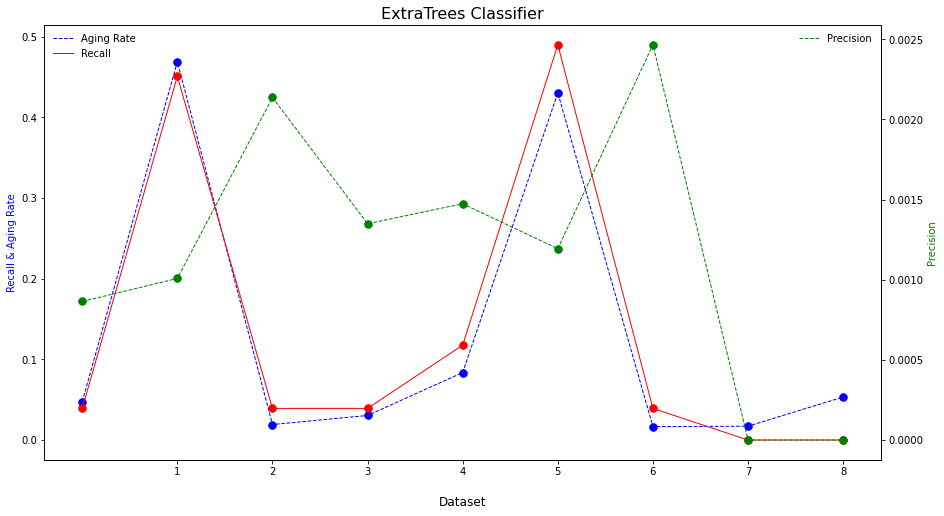

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,2.0,2312.0,49.0,46286.0,0.000864,0.039216,0.047565,0.824462,0.000846,0.000000
dataset2,1.000000,2974.0,2974.0,23.0,22792.0,28.0,25806.0,0.001008,0.450980,0.468972,0.961637,0.001006,0.000000
dataset3,1.000000,3038.0,3038.0,2.0,934.0,49.0,47664.0,0.002137,0.039216,0.019240,2.038252,0.002026,0.043580
dataset4,1.000000,3038.0,3038.0,2.0,1480.0,49.0,47118.0,0.001350,0.039216,0.030463,1.287317,0.001305,0.032446
dataset5,1.006623,3040.0,3020.0,6.0,4065.0,45.0,44533.0,0.001474,0.117647,0.083681,1.405898,0.001456,0.103285
dataset6,1.012996,3040.0,3001.0,25.0,20922.0,26.0,27676.0,0.001193,0.490196,0.430574,1.138471,0.001191,0.372594
dataset7,1.000000,3040.0,3040.0,2.0,809.0,49.0,47789.0,0.002466,0.039216,0.016670,2.352409,0.002320,0.047438
dataset8,1.000000,3040.0,3040.0,0.0,834.0,51.0,47764.0,0.000000,0.000000,0.017143,0.000000,NaN,0.000000
dataset9,10.000000,3040.0,304.0,0.0,2594.0,51.0,46004.0,0.000000,0.000000,0.053321,0.000000,NaN,0.000000


In [6]:
line_chart(table_setC, title = 'ExtraTrees Classifier')
table_setC

### Export

In [7]:
savedate = '20220506'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'ExtraTrees_m2-4_m5'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'ExtraTrees_m2-4_m5')